# Buckley-Leverett Solution Demonstration

**Author: Andrew Z. Miller**

This demonstration showcases the semi-analytical Buckley-Leverett solution, which serves as a validation tool for multiphase flow simulators. The solution models the displacement of oil by water in a one-dimensional reservoir, accounting for relative permeabilities using the Corey-Brooks model.

The implemented class includes key functions such as `compute_saturation_profile()`, which calculates the full (inadmissible) saturation profile based on fractional flow. To handle the shock front correctly, the mass balance across the discontinuity leads to the equation:

$$
\frac{f(S_{wf})}{S_{wf} - S_{wi}} - \frac{\partial f(S_{wf})}{\partial S} = 0
$$

where $f$ is the fractional flow function, $S_{wi}$ is the initial water saturation, and $S_{wf}$ is the saturation at the shock front. This nonlinear equation is solved in `compute_saturation_front()` using `scipy.optimize.root_scalar` for numerical accuracy.

Once $S_{wf}$ is determined, the profile is adjusted to reflect the physical shock. The function `plot_saturation_profile(t)` generates the corrected saturation profile at a specified non-dimensional time $t$. An example plot for $t=0.25$ is shown below:

![Saturation Profile](images/saturation_profile.png)

These visualization tools help in understanding the solution dynamics. The shock front saturation values can be computed for various scenarios to verify simulator accuracy.

In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import yaml

class BuckleyLeverett(object):
    
    def __init__(self, inputs):
        
        if isinstance(inputs, str):
            with open(inputs) as f:
                self.inputs = yaml.load(f, yaml.FullLoader)
        else:
            self.inputs = inputs
            
        self.Sor = self.inputs['reservoir']['oil']['residual saturation']
        self.Swc = self.inputs['reservoir']['water']['critical saturation']
        self.nw = self.inputs['reservoir']['water']['corey-brooks exponent']
        self.no = self.inputs['reservoir']['oil']['corey-brooks exponent']
        self.krw_max = self.inputs['reservoir']['water']['max relative permeability']
        self.kro_max = self.inputs['reservoir']['oil']['max relative permeability']
        
        self.mu_o = self.inputs['fluid']['oil']['viscosity']
        self.mu_w = self.inputs['fluid']['water']['viscosity']
        
        self.Swi = self.inputs['initial conditions']['water saturation']
        
        self.step = 0.01
    
    def water_rel_perm(self, S):
        return self.krw_max * ((S - self.Swc) / (1 - self.Sor - self.Swc)) ** self.nw
    
    def oil_rel_perm(self, S):
        return self.kro_max * (((1 - S) - self.Sor) / (1 - self.Sor - self.Swc)) ** self.no
    
    def fractional_flow(self, S):
        krw = self.water_rel_perm(S)
        kro = self.oil_rel_perm(S)
        return (krw / self.mu_w) / (krw / self.mu_w + kro / self.mu_o)

    def d_fractional_flow_dS(self, S):
        
        a = 1 - self.Sor - self.Swc
        Se_w = (S - self.Swc) / a
        Se_o = (1 - S - self.Sor) / a
        
        krw = self.krw_max * Se_w ** self.nw
        kro = self.kro_max * Se_o ** self.no
        
        lw = krw / self.mu_w
        lo = kro / self.mu_o
        
        dkrw_dS = self.krw_max * self.nw * Se_w ** (self.nw - 1) * (1 / a)
        dkro_dS = self.kro_max * self.no * Se_o ** (self.no - 1) * (-1 / a)
        
        dlw_dS = dkrw_dS / self.mu_w
        dlo_dS = dkro_dS / self.mu_o
        
        return (dlw_dS * lo - lw * dlo_dS) / (lw + lo)**2
    
    def compute_saturation_front(self):
        
        def g(S):
            f_wf = self.fractional_flow(S)
            return f_wf / (S - self.Swi) - self.d_fractional_flow_dS(S)
        
        x_mid = (self.Swi + (1 - self.Sor)) / 2
        return scipy.optimize.root_scalar(g, method='secant', x0=self.Swi + 0.1, x1=x_mid).root
        
    def compute_saturation_profile(self):
        
        Swi = self.inputs['initial conditions']['water saturation']
        
        S = np.arange(self.Swi + self.step, (1 - self.Swc), self.step)
        
        x = self.d_fractional_flow_dS(S)
        
        return (x, S)
    
    def plot_fractional_flow(self):
        
        S = np.arange(self.Swi + self.step, (1-self.Swc), self.step)
        
        f = self.fractional_flow(S)
        
        plt.plot(S, f)
        plt.xlabel('$S_w$')
        plt.ylabel('$f$')
    
    def plot_full_saturation_profile(self):
        
        x, S = self.compute_saturation_profile()
        
        plt.plot(x, S)
        plt.ylabel('$S_w$')
        plt.xlabel('$x$')
        
    def plot_saturation_profile(self, t):
        
        x, S = self.compute_saturation_profile()
        
        Swf = self.compute_saturation_front()
        
        S1 = S[S > Swf]
        x1 = x[S > Swf] * t
        
        xD = self.d_fractional_flow_dS(Swf) * t
        
        S = np.concatenate((S1[::-1], np.array([Swf, self.Swi]), np.array([self.Swi])))
        x = np.concatenate((x1[::-1], np.array([xD, xD]), np.array([1.0])))
        
        plt.plot(x, S)
        plt.xlabel(r'$x$')
        plt.ylabel(r'$S_w$')

In [2]:
#Uncomment the following lines for viewing the plot
#%matplotlib inline
#pr = BuckleyLeverett('inputs.yml')
#pr.plot_saturation_profile(0.25)


In [3]:
#If you want, uncomment the following lines to produce an interative plot.
#from ipywidgets import interact
#@interact(t=(0,0.44,0.001))
#def iplot(t=0):
#    return pr.plot_saturation_profile(t)

## Verification Exercise

In [4]:
%matplotlib inline
inputs = {
    'reservoir': {
        'oil': {'residual saturation': 0.2, 'corey-brooks exponent': 3.0, 'max relative permeability': 0.2},
        'water': {'critical saturation': 0.2, 'corey-brooks exponent': 3.0, 'max relative permeability': 1.0},
    },
    'fluid': {
        'oil': {'viscosity': 1.0},
        'water': {'viscosity': 1.0},
    },
    'initial conditions': {'water saturation': 0.2},
}
bl = BuckleyLeverett(inputs)
S_test = 0.5
print("df/dS at S=0.5:", bl.d_fractional_flow_dS(S_test))

df/dS at S=0.5: 2.7777777777777777


Text(0, 0.5, 'df/dS')

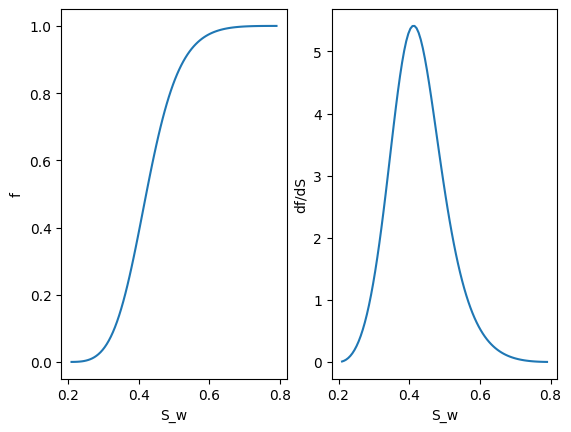

In [5]:
S = np.linspace(0.21, 0.79, 100)
f = [bl.fractional_flow(s) for s in S]
df = [bl.d_fractional_flow_dS(s) for s in S]
plt.subplot(1,2,1)
plt.plot(S, f); plt.xlabel('S_w'); plt.ylabel('f')
plt.subplot(1,2,2)
plt.plot(S, df); plt.xlabel('S_w'); plt.ylabel('df/dS')